In [1]:
import numpy as np
from data_preprocess import load_ratings_data, Environment

In [2]:
file_path = "./ml-100k"

ratings, full_users, full_movies = load_ratings_data(file_path, [0, 1])
initial_ratings, _, _ = load_ratings_data(file_path, [0.0, 0.0], full_users, full_movies)

In [3]:
class RandomRecommendation():
    def __init__(self, N_user, N_item):
        self.N_user = N_user
        self.N_item = N_item
    
    def predict(self, user_id, options, prev_rewards):
        return np.random.choice(options)
    
    def update(self, user_id, item_id, rating):
        pass

class NaiveEpsilonGreedy():
    def __init__(self, N_user, N_item, epsilon=0.1):
        self.epsilon = epsilon
        self.N_user = N_user
        self.N_item = N_item
        self.item_sum = np.zeros(N_item)
        self.item_count = np.zeros(N_item, dtype=np.int64) 
    
    def predict(self, user_id, options, prev_rewards):
        if np.random.rand() < self.epsilon:
            return np.random.choice(options)
        else:
            item_sum = self.item_sum[options]
            item_count = self.item_count[options]
            est_rating = np.where(item_count > 0, item_sum / item_count, 0) 
            est_rating = est_rating + np.random.randn(len(est_rating)) * 1e-4 #(to break a tie)
            return options[np.argmax(est_rating)]
    
    def update(self, user_id, item_id, rating):
        self.item_sum[item_id] += rating
        self.item_count[item_id] += 1


class PTS():
    def __init__(self, N_user, N_item, D, N_particles, sigma=0.5):
        self.D = D
        self.N_particles = N_particles
        self.w = np.ones(N_particles) / N_particles
        self.user_features = np.zeros(N_particles, N_user, D)
        self.item_features = np.zeros(N_particles, N_item, D)
        self.sigma = 0.5
    
    def predict(self, user_id, options, prev_rewards):
        particle = np.random.choice(self.N_particles, p=self.w)
        item_v = self.item_features[particle]
        prev_idx = prev_rewards[user_id].indices
        # Sample from P(User_i| Items, ratings)
        prev_item_v = item_v[prev_idx]
        user_Sig = np.linalg.inv(
            self.sigma ** (-2) * item_v[prev_idx].T @ item_v[prev_idx] + np.eye(self.D)
        )
        user_v = self.sigma ** (-2) * user_Sig @ item_v[prev_idx].T @ prev_rewards[user_id].data
        user_v = np.random.multivariate_normal(user_v, user_Sig)
        # Estimate the best movie
        recommendation = np.argmax(user_v @ item_v[options].T)
        return recommendation


    def update(self, user_id, item_id, rating):
        


In [4]:
from tqdm import tqdm


def experiment(Horizon, model, env):
    users = set(range(env.gt_rating.shape[0]))
    acc_regret = [0]
    for i in tqdm(range(Horizon)):
        user_id = np.random.choice(list(users))
        options = env.option(user_id)
        if len(options) == 0:
        # No new movies recommended for the user
            users.remove(user_id)
            continue 

        recommend_id = model.predict(user_id, options, env.prev_rating)
        gt_rating, regret = env.update(user_id, recommend_id)
        model.update(user_id, recommend_id, gt_rating)
        acc_regret.append(acc_regret[-1] + regret)
    return acc_regret


In [5]:
Horizon = 50000
results = {}


env = Environment(ratings, initial_ratings)
model = RandomRecommendation(ratings.shape[0], ratings.shape[1])
results["random"] = experiment(Horizon, model, env)

100%|██████████| 50000/50000 [00:32<00:00, 1548.03it/s]


In [6]:
env = Environment(ratings, initial_ratings)
model = NaiveEpsilonGreedy(ratings.shape[0], ratings.shape[1])
results["e-greedy"] = experiment(Horizon, model, env)

  0%|          | 0/50000 [00:00<?, ?it/s]C:\Users\a2576\AppData\Local\Temp\ipykernel_3372\1154623002.py:26: RuntimeWarning: invalid value encountered in divide
  est_rating = np.where(item_count > 0, item_sum / item_count, 0)
100%|██████████| 50000/50000 [00:35<00:00, 1424.80it/s]


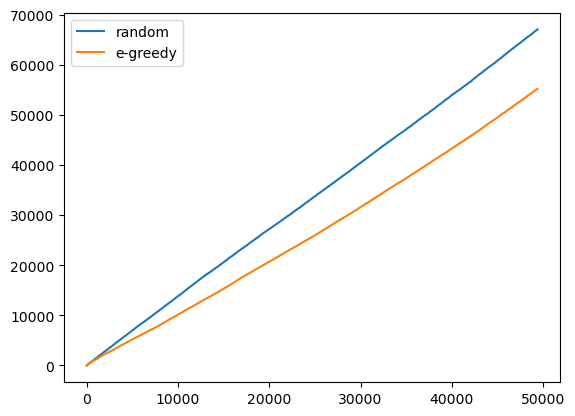

In [9]:
from matplotlib import pyplot as plt

plt.plot(results["random"], label="random")
plt.plot(results["e-greedy"], label="e-greedy")

plt.legend()